# Proyecto de Regresión Lineal Regularizada (Lasso)

**OBJETIVO DEL PROYECTO:**
Analizar la relación entre recursos sanitarios y factores socio-demográficos en condados de EE.UU. mediante modelos de regresión, identificando qué variables demográficas influyen significativamente en la distribución de recursos de salud.

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [14]:
# CARGA DE DATOS Y VISUALIZACION
url = "https://breathecode.herokuapp.com/asset/internal-link?id=733&path=demographic_health_data.csv"
df = pd.read_csv(url)

print("Dimensiones del dataset:", df.shape)
df.head()

Dimensiones del dataset: (3140, 108)


,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,...,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,1001,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,...,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3
1,1003,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,...,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4
2,1005,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,...,2373,19.7,18.6,20.6,3870,4.5,4.2,4.8,887,6
3,1007,22400,2456,10.964286,2596,11.589286,3029,13.522321,3113,13.897321,...,1789,14.1,13.2,14.9,2511,3.3,3.1,3.6,595,2
4,1009,57840,7095,12.266598,7570,13.087828,6742,11.656293,6884,11.901798,...,4661,13.5,12.6,14.5,6017,3.4,3.2,3.7,1507,2


In [15]:
# INFO GENERAL DEL DATASET Y ESTADÍSTICOS DESCRIPTIVOS BÁSICOS
print("INFORMACIÓN GENERAL DEL DATASET:")
print(df.info())

print("\nESTADÍSTICOS DESCRIPTIVOS BÁSICOS:")
print(df.describe())


INFORMACIÓN GENERAL DEL DATASET:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB
None

ESTADÍSTICOS DESCRIPTIVOS BÁSICOS:
               fips       TOT_POP           0-9  0-9 y/o % of total pop  \
count   3140.000000  3.140000e+03  3.140000e+03             3140.000000   
mean   30401.640764  1.041894e+05  1.274030e+04               11.871051   
std    15150.559265  3.335834e+05  4.180730e+04                2.124081   
min     1001.000000  8.800000e+01  0.000000e+00                0.000000   
25%    18180.500000  1.096325e+04  1.280500e+03               10.594639   
50%    29178.000000  2.580050e+04  3.057000e+03               11.802727   
75%    45081.500000  6.791300e+04  8.097000e+03               12.951840   
max    56045.000000  1.010552e+07  1.208253e+06               25.460677   

             19-Oct  10-19 y/o % of total pop         20-29  \
co

In [16]:
# VERIFICACION DE NULOS
print("Valores nulos por columna:")
print(df.isnull().sum())

# VERIFICACION DE DUPLICADOS
print(f"Filas duplicadas: {df.duplicated().sum()}")


Valores nulos por columna:
fips                      0
TOT_POP                   0
0-9                       0
0-9 y/o % of total pop    0
19-Oct                    0
                         ..
CKD_prevalence            0
CKD_Lower 95% CI          0
CKD_Upper 95% CI          0
CKD_number                0
Urban_rural_code          0
Length: 108, dtype: int64
Filas duplicadas: 0


No tenemos filas duplicadas ni valores nulos en el dataset

In [17]:
print("LISTA COMPLETA DE VARIABLES")
for i, columna in enumerate(df.columns):
    print(f"{i+1:2d}. {columna}")

LISTA COMPLETA DE VARIABLES
 1. fips
 2. TOT_POP
 3. 0-9
 4. 0-9 y/o % of total pop
 5. 19-Oct
 6. 10-19 y/o % of total pop
 7. 20-29
 8. 20-29 y/o % of total pop
 9. 30-39
10. 30-39 y/o % of total pop
11. 40-49
12. 40-49 y/o % of total pop
13. 50-59
14. 50-59 y/o % of total pop
15. 60-69
16. 60-69 y/o % of total pop
17. 70-79
18. 70-79 y/o % of total pop
19. 80+
20. 80+ y/o % of total pop
21. White-alone pop
22. % White-alone
23. Black-alone pop
24. % Black-alone
25. Native American/American Indian-alone pop
26. % NA/AI-alone
27. Asian-alone pop
28. % Asian-alone
29. Hawaiian/Pacific Islander-alone pop
30. % Hawaiian/PI-alone
31. Two or more races pop
32. % Two or more races
33. POP_ESTIMATE_2018
34. N_POP_CHG_2018
35. GQ_ESTIMATES_2018
36. R_birth_2018
37. R_death_2018
38. R_NATURAL_INC_2018
39. R_INTERNATIONAL_MIG_2018
40. R_DOMESTIC_MIG_2018
41. R_NET_MIG_2018
42. Less than a high school diploma 2014-18
43. High school diploma only 2014-18
44. Some college or associate's degree 201

In [18]:
# BUSCANDO VARIABLES OBJETIVO
print("ENFERMEDADES (OBJETIVO):")
objetivos = [col for col in df.columns if any(palabra in col.lower() for palabra in 
              ['obesity', 'disease', 'diabetes'])]
for obj in objetivos:
    print(f"• {obj}")

ENFERMEDADES (OBJETIVO):
• Obesity_prevalence
• Obesity_Lower 95% CI
• Obesity_Upper 95% CI
• Obesity_number
• Heart disease_prevalence
• Heart disease_Lower 95% CI
• Heart disease_Upper 95% CI
• Heart disease_number
• diabetes_prevalence
• diabetes_Lower 95% CI
• diabetes_Upper 95% CI
• diabetes_number


In [19]:
# BUSCAR VARIABLES PREDICTORAS
#VARIBLES RECURSOS SANITARIOS
print("RECURSOS SANITARIOS (PREDICTORES):")
predictores_1 = [col for col in df.columns if any(palabra in col.lower() for palabra in 
              ['physician', 'hospital', 'nurse', 'bed', 'medical', 'care'])]
for obj in predictores_1:
    print(f"• {obj}")
# VARIABLES SOCIO-DEMOGRÁFICAS
print("VARIABLES SOCIO-DEMOGRÁFICAS (PREDICTORES):")
predictores_2 = [col for col in df.columns if any(palabra in col.lower() for palabra in 
               ['pop', 'age', 'education', 'diploma', 'income', 'poverty', 'employment', 'race', 'white', 'black', 'asian', 'rural', 'urban'])]

for pred in predictores_2:
    print(f"• {pred}")

RECURSOS SANITARIOS (PREDICTORES):
• Active Physicians per 100000 Population 2018 (AAMC)
• Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)
• Active Primary Care Physicians per 100000 Population 2018 (AAMC)
• Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)
• Active Patient Care General Surgeons per 100000 Population 2018 (AAMC)
• Total nurse practitioners (2019)
• Total physician assistants (2019)
• Total Hospitals (2019)
• Internal Medicine Primary Care (2019)
• Family Medicine/General Practice Primary Care (2019)
• Total Specialist Physicians (2019)
• ICU Beds_x
VARIABLES SOCIO-DEMOGRÁFICAS (PREDICTORES):
• TOT_POP
• 0-9 y/o % of total pop
• 10-19 y/o % of total pop
• 20-29 y/o % of total pop
• 30-39 y/o % of total pop
• 40-49 y/o % of total pop
• 50-59 y/o % of total pop
• 60-69 y/o % of total pop
• 70-79 y/o % of total pop
• 80+ y/o % of total pop
• White-alone pop
• % White-alone
• Black-alone pop
• % Black-alone
• Native America

# **Selección de variables**

Tras revisar el dataset, se ha decidido quedarnos únicamente con las variables más representativas de cada grupo, evitando redundancia y mejorando la interpretabilidad del modelo.

**Variable objetivo:**

- Obesity_prevalence

**Variables predictoras sanitarias:**

- Active Primary Care Physicians per 100000 Population 2018 (AAMC)

- Total nurse practitioners (2019)

- Total Hospitals (2019)

- ICU Beds_x

**Variables predictoras socio-demográficas:**

- Percent of Population Aged 60+

- Percent of adults with a high school diploma only 2014-18

- Median_Household_Income_2018

- Unemployment_rate_2018

Estas variables fueron seleccionadas por su relevancia conceptual y por cubrir diferentes dimensiones del problema:

Sanitarias: acceso, personal, infraestructura y capacidad hospitalaria.

Demográficas: edad, educación, ingresos y empleo.

A continuación procedemos a buscar las relaciones entre los dos grupos de variables predictoras y despues, la relacion de éstas con la variable objetivo. Para ello separamos las variables predictoras en numericas y categóricas.

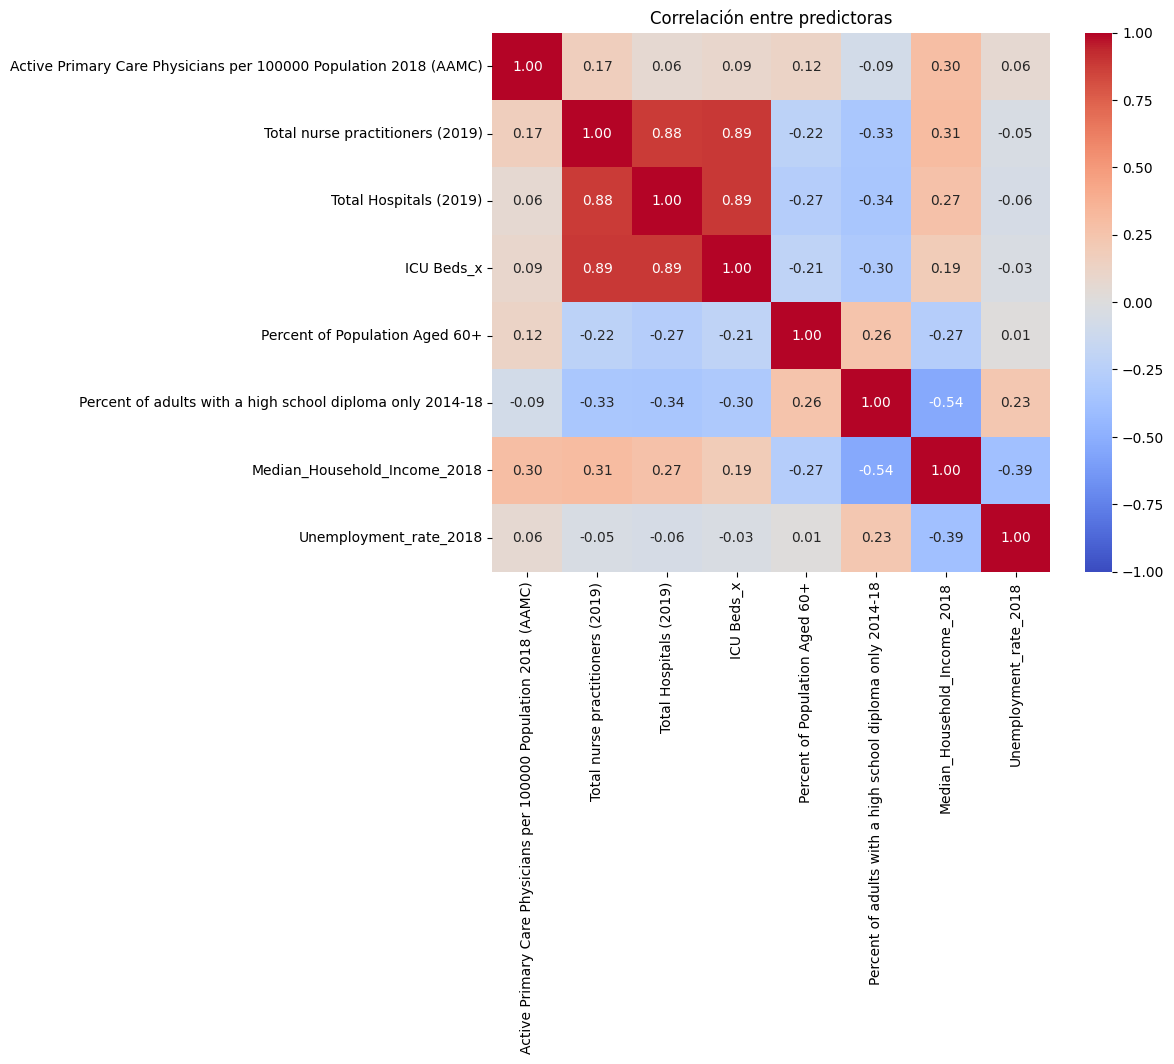

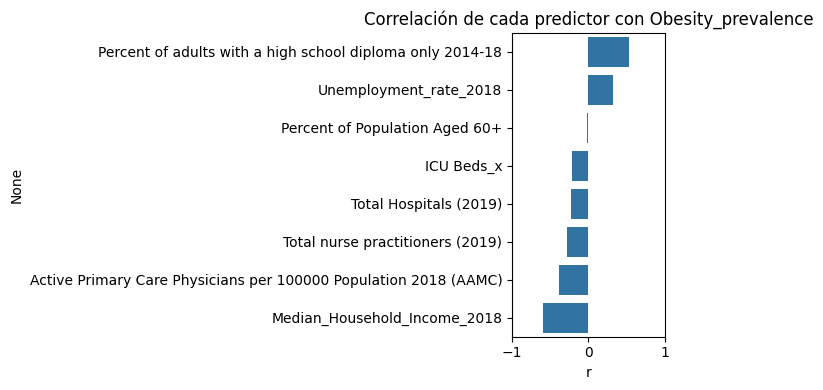

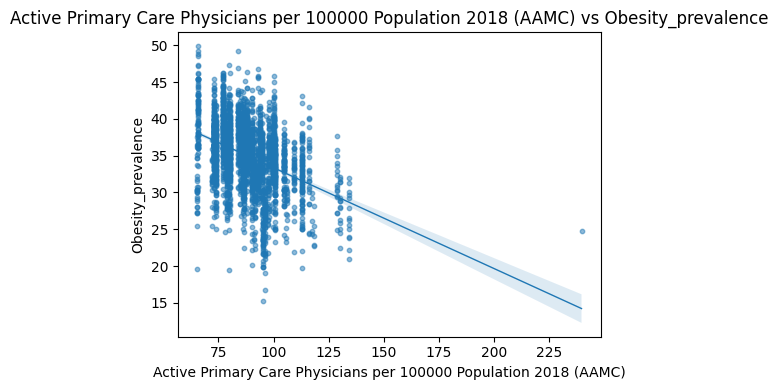

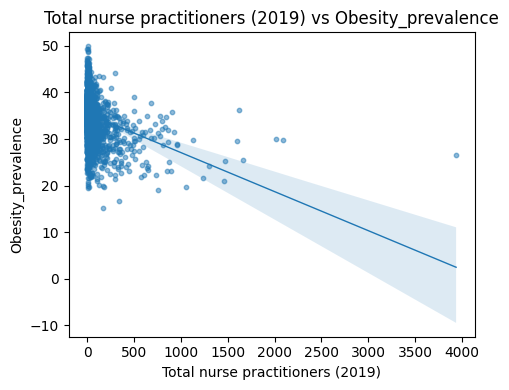

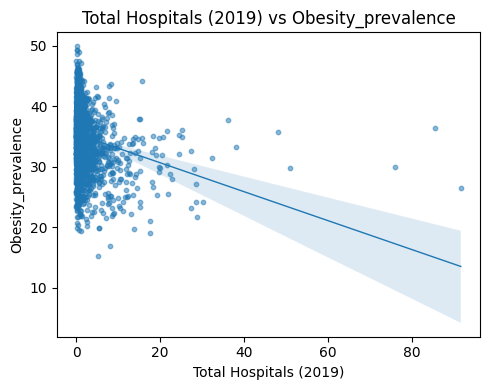

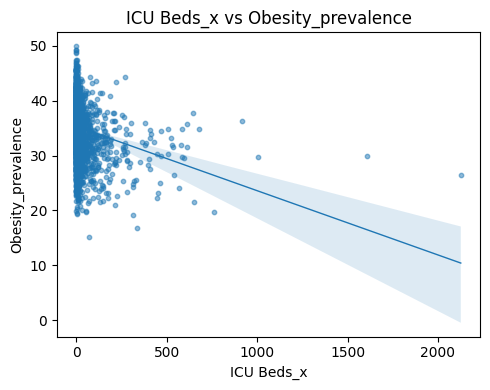

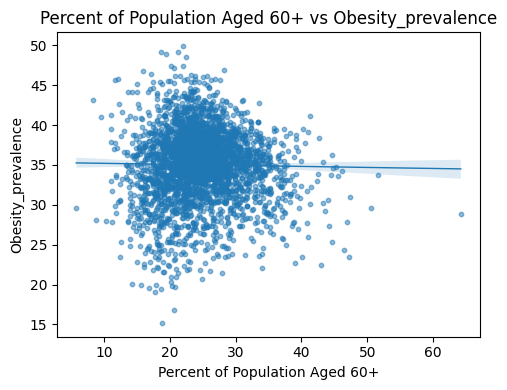

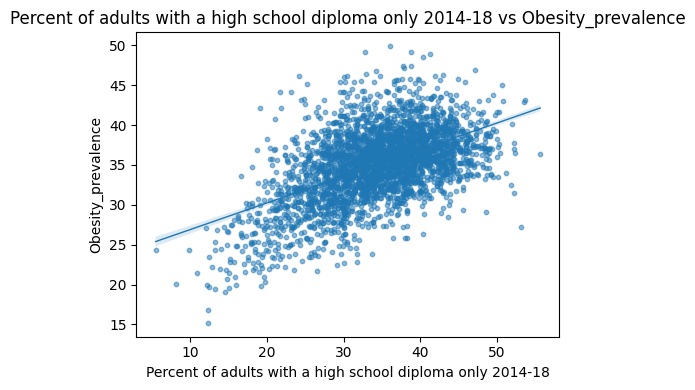

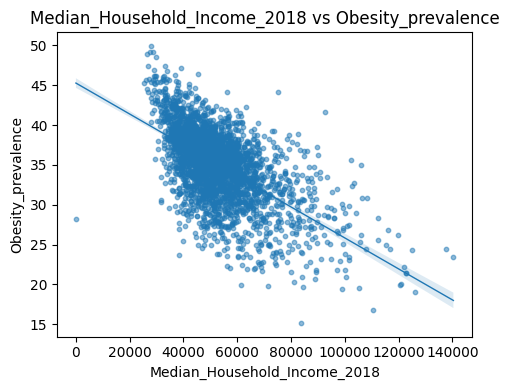

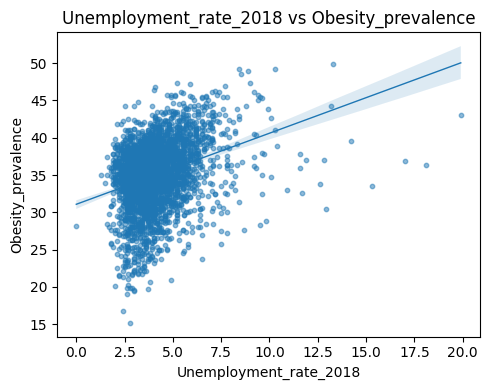

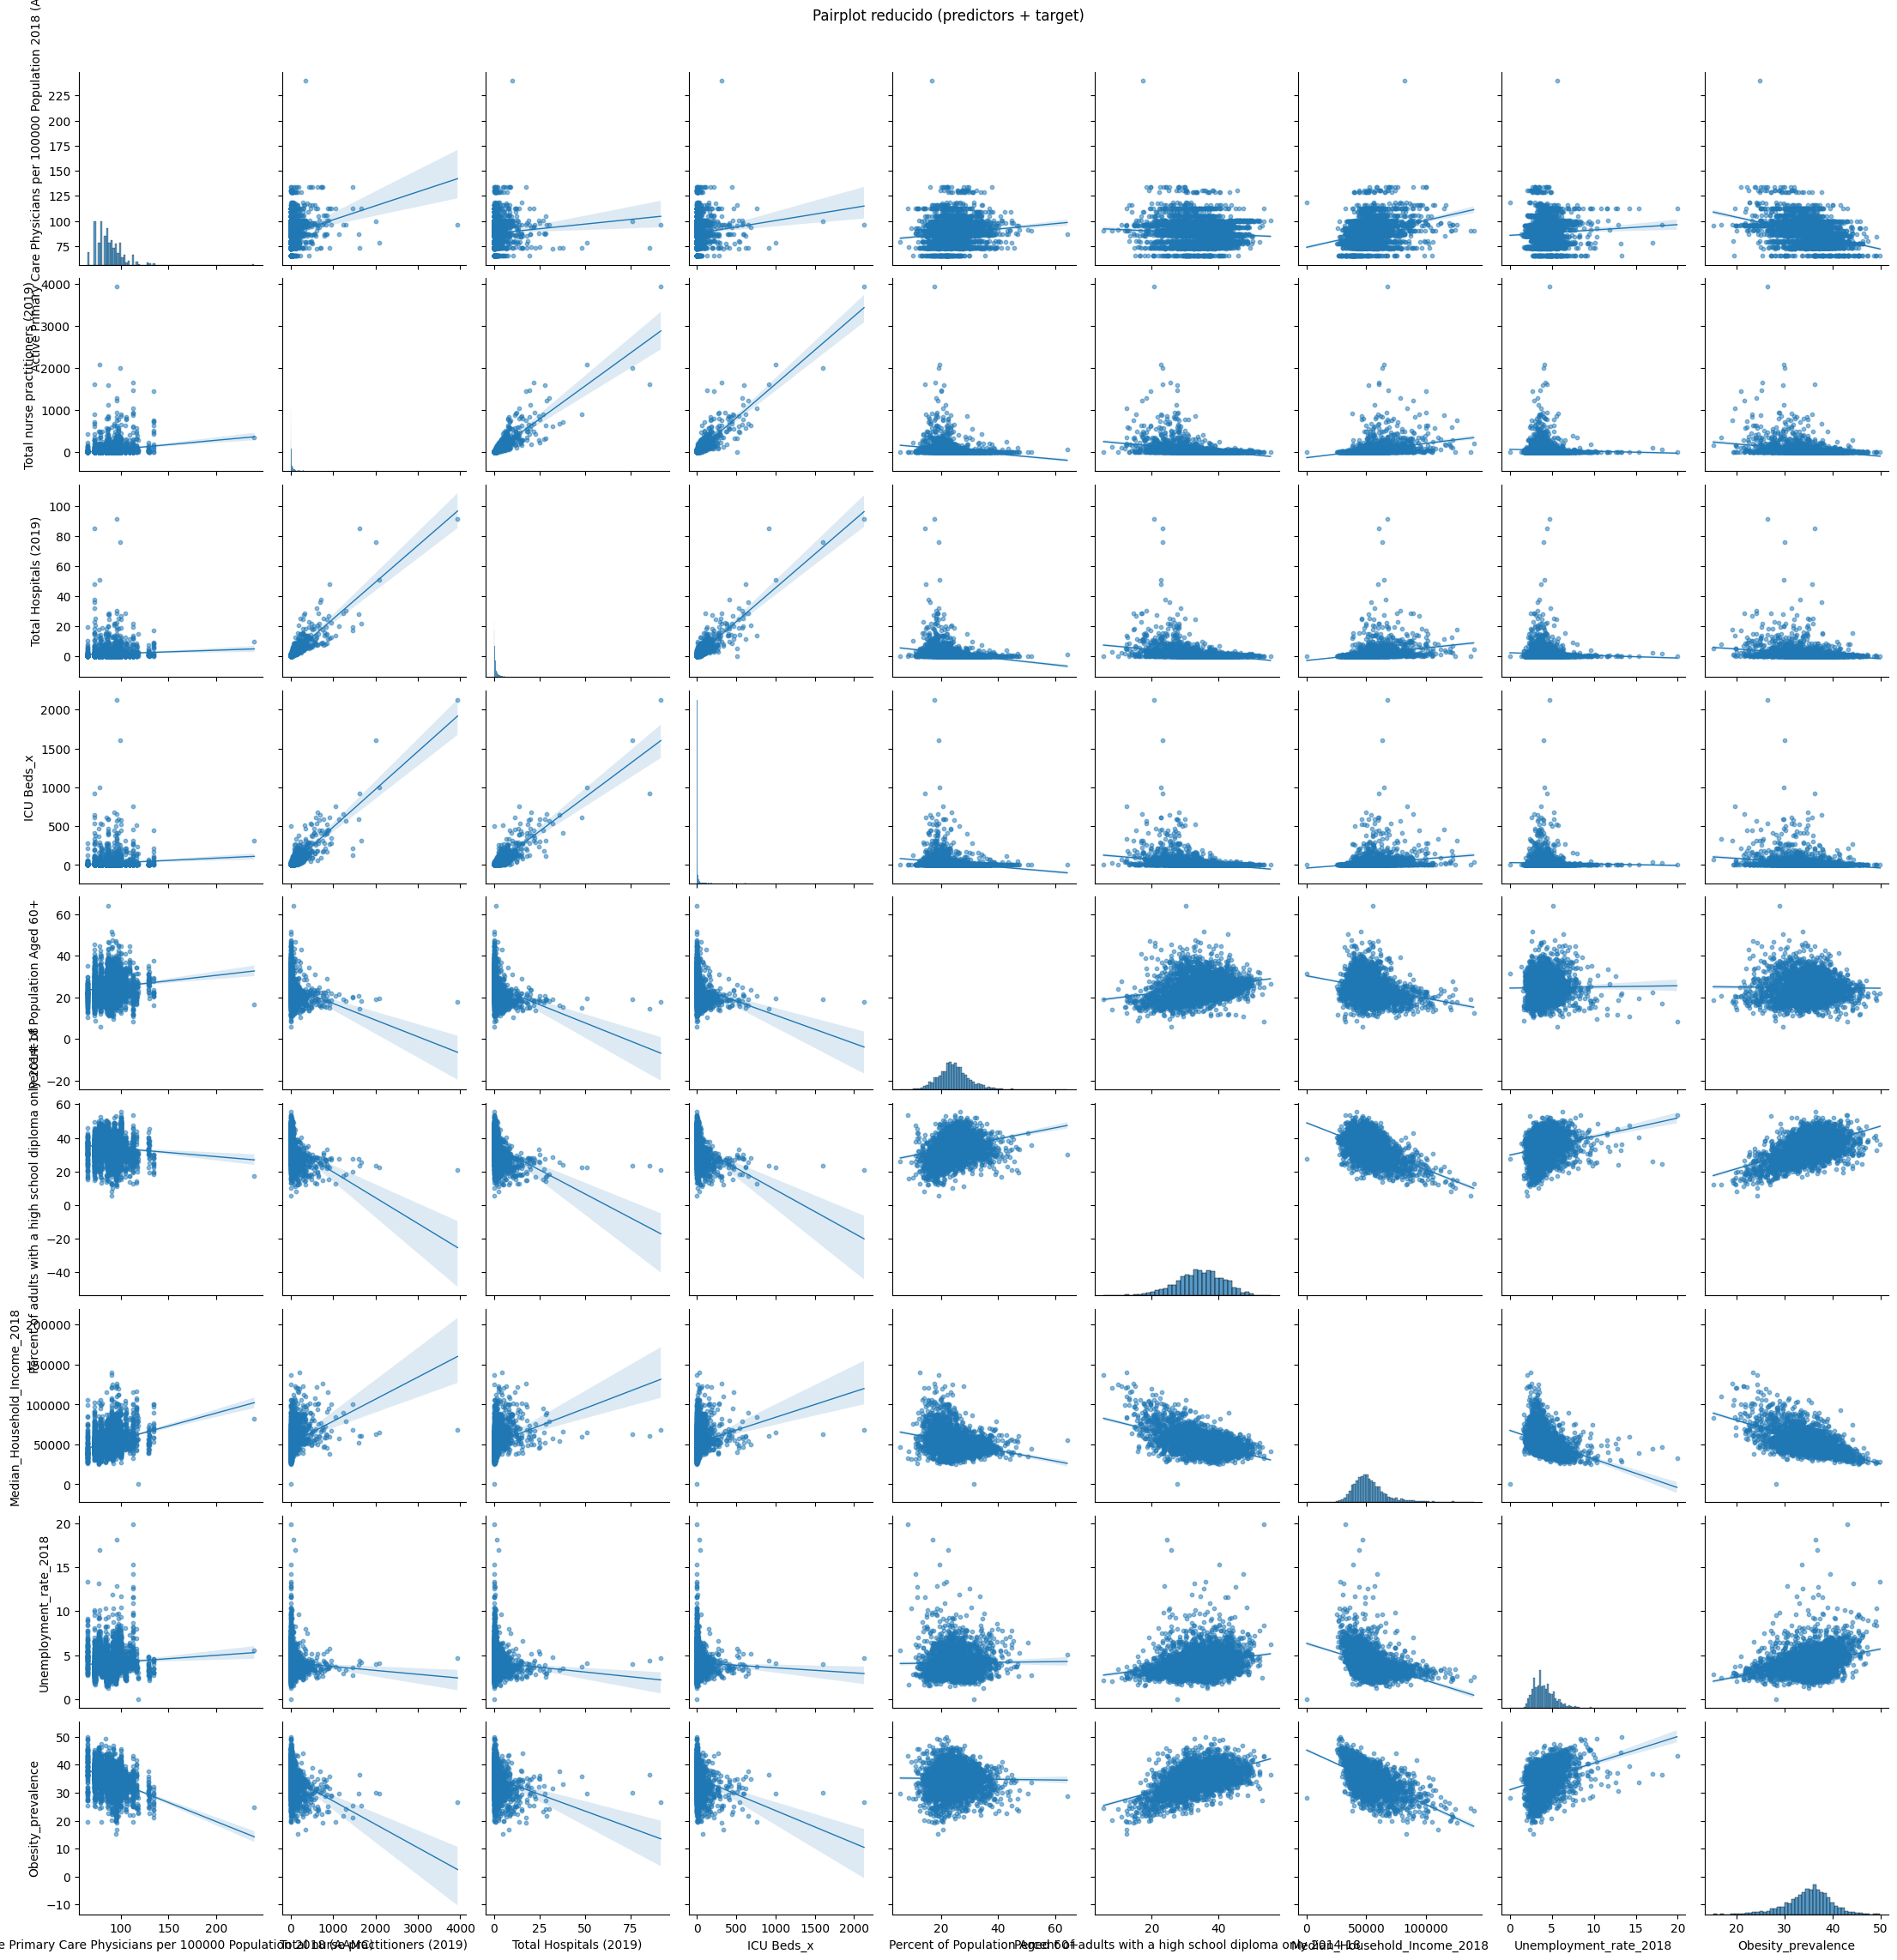

In [23]:
# ANÁLISIS DE RELACIONES ENTRE VARIABLES
sanitarias = [
    "Active Primary Care Physicians per 100000 Population 2018 (AAMC)",
    "Total nurse practitioners (2019)",
    "Total Hospitals (2019)",
    "ICU Beds_x"
]

sociodemo = [
    "Percent of Population Aged 60+",
    "Percent of adults with a high school diploma only 2014-18",
    "Median_Household_Income_2018",
    "Unemployment_rate_2018"
]

target = "Obesity_prevalence"

predictors = sanitarias + sociodemo

# Subset limpio
df_sub = df[predictors + [target]].copy()

# 1) Correlación entre predictoras (matriz) — identifica multicolinealidad
plt.figure(figsize=(9,7))
corr = df_sub[predictors].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlación entre predictoras")
plt.show()

# 2) Correlación predictoras vs target (barra ordenada) — prioriza features
corr_with_target = df_sub[predictors + [target]].corr()[target].drop(target).sort_values(ascending=False)
plt.figure(figsize=(7,4))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title("Correlación de cada predictor con Obesity_prevalence")
plt.xlabel("r")
plt.xlim(-1,1)
plt.tight_layout()
plt.show()

# 3) Scatter + regresión lineal simple: cada predictor vs target (visualización robusta)
for col in predictors:
    plt.figure(figsize=(5,4))
    sns.regplot(data=df_sub, x=col, y=target, scatter_kws={'s':10, 'alpha':0.5}, line_kws={'lw':1})
    plt.title(f"{col} vs {target}")
    plt.tight_layout()
    plt.show()

# 4) Pairplot reducido (opcional: muestra relación entre predictors y target)
sns.pairplot(df_sub[predictors + [target]], kind="reg", plot_kws={'scatter_kws':{'s':10, 'alpha':0.5}, 'line_kws':{'lw':1}})
plt.suptitle("Pairplot reducido (predictors + target)", y=1.02)
plt.show()
